In [ ]:
!pip install -q kaggle 

from google.colab import files
files.upload()  # сюда нужно вставить сгенерированный json с kaggle 

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"sklaa00","key":"bc6181e806be88d9938b1360d12c98b2"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c spring-2022-property-prices

import zipfile
zip_ref = zipfile.ZipFile('spring-2022-property-prices.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

spring-2022-property-prices.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
!pip install xgboost==0.90
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [3]:
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import auc, f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")



%matplotlib inline

In [ ]:
sample_df = pd.read_csv('./files/SampleSubmission.csv')
test_df = pd.read_csv('./files/Test.csv')
train_df = pd.read_csv('./files/Train.csv')

In [ ]:
train_df.head()

,id,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
0,0,2011-1,560,NaN,2,59,3,0,30.0,1.0,...,0,0,0,0,0,0,0,0,0,4510000
1,1,2011-1,667,NaN,10,50,2,1,25.0,NaN,...,0,0,0,0,0,0,0,0,0,13231000
2,2,2011-1,90,0.0,1,48,2,0,25.0,0.0,...,0,0,0,0,0,0,0,0,0,2008000
3,3,2011-1,94,1.0,3,62,3,1,30.0,NaN,...,0,0,0,0,0,0,0,0,0,12680000
4,4,2011-1,232,0.0,3,60,3,0,25.0,NaN,...,0,0,0,0,0,0,0,0,0,3335000


In [ ]:
test_df.head()

,id,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,...,kw4,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13
0,100000,2012-3,459,NaN,1,60,3,1,30.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,100001,2012-3,344,1.0,10,52,2,1,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,100002,2012-3,585,0.0,4,54,3,0,30.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,100003,2012-3,494,NaN,2,52,2,1,25.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,100004,2012-3,622,1.0,9,60,3,1,15.0,NaN,...,0,0,0,0,0,0,0,0,0,0


# Предобработка датасета

In [ ]:
train_df["build_tech"][train_df["build_tech"].isna() == True] = train_df["build_tech"].mean()
train_df["g_lift"][train_df["g_lift"].isna() == True] = train_df["g_lift"].mean()
train_df["date"] = train_df["date"].str.replace("-", "").astype(int)
train_df["metro_dist"][train_df["metro_dist"].isna() == True] = train_df["metro_dist"].mean()

X = train_df.iloc[:, 1:-1]
y = train_df.loc[:, "price"].astype(int)

In [ ]:
test_df["build_tech"][test_df["build_tech"].isna() == True] = test_df["build_tech"].mean()
test_df["g_lift"][test_df["g_lift"].isna() == True] = test_df["g_lift"].mean()
test_df["date"] = test_df["date"].str.replace("-", "").astype(int)
test_df["metro_dist"][test_df["metro_dist"].isna() == True] = test_df["metro_dist"].mean()

X_kaggle = test_df.iloc[:, 1:]

In [ ]:
# le = LabelEncoder()
# y = le.fit_transform(y)
# y

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

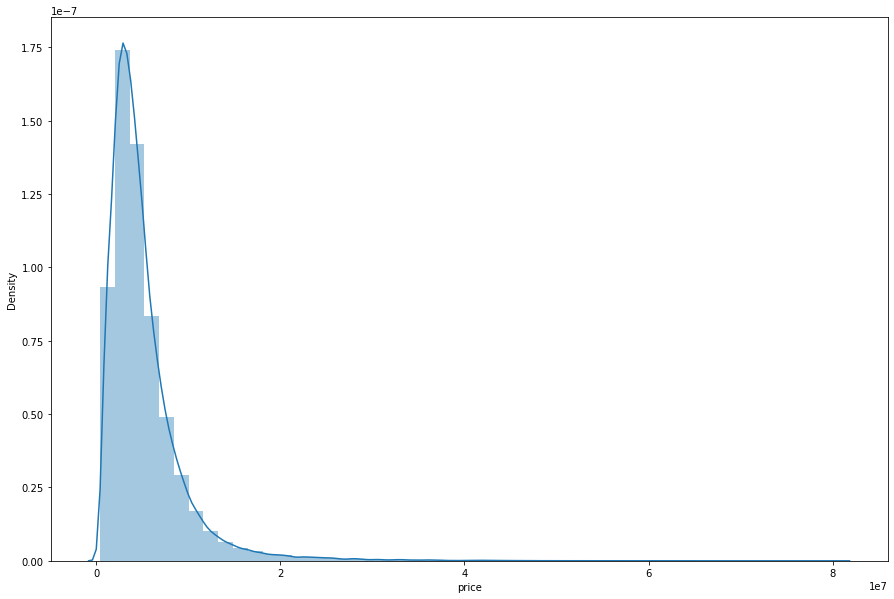

In [ ]:
sns.distplot(y).figure.set_size_inches(15, 10)

# Вычисления

## LR

In [ ]:
# LR = LogisticRegression()
# LR.fit(X_train, y_train)
# lr_ans = LR.predict(X_test)
# print_metrics(y_train, lr_ans)

## LightGBM Regression

In [ ]:
lgbmr = LGBMRegressor(n_estimators=1000
                      , max_depth=10
                    #   , max_features="log2"
                      )

lgbmr.fit(X_train, y_train)
y_pred = (lgbmr.predict(X_test))

print("Test MAE = %.4f" % mean_absolute_error(y_test, y_pred))

Test MAE = 1343195.6016


## XGBOOST Regression

In [1]:
xgbr = XGBRegressor(n_estimators=1000
                    , max_depth=10
                    , learning_rate=0.1
                    , max_features=X.shape[0]//3
                    )

xgbr.fit(X_train, y_train)
y_pred = (xgbr.predict(X_test))

print("Test MAE = %.4f" % mean_absolute_error(y_test, y_pred))

NameError: ignored

## CatBoostRegressor

In [ ]:
cbr = CatBoostRegressor(iterations=1000,
                          learning_rate=0.1,
                          depth=10
                        )

cbr.fit(X_train, y_train)
y_pred = (cbr.predict(X_test))

print("Test MAE = %.4f" % mean_absolute_error(y_test, y_pred))



0:	learn: 3998668.3968142	total: 86.4ms	remaining: 1m 26s
1:	learn: 3826292.7862842	total: 158ms	remaining: 1m 19s
2:	learn: 3676010.4952753	total: 222ms	remaining: 1m 13s
3:	learn: 3547352.7665624	total: 311ms	remaining: 1m 17s
4:	learn: 3429020.5645516	total: 378ms	remaining: 1m 15s
5:	learn: 3334126.5237539	total: 455ms	remaining: 1m 15s
6:	learn: 3254128.4603219	total: 493ms	remaining: 1m 9s
7:	learn: 3179033.5561274	total: 564ms	remaining: 1m 9s
8:	learn: 3116261.2496473	total: 644ms	remaining: 1m 10s
9:	learn: 3060245.8474794	total: 717ms	remaining: 1m 10s
10:	learn: 3014196.7933581	total: 789ms	remaining: 1m 10s
11:	learn: 2972307.1747006	total: 858ms	remaining: 1m 10s
12:	learn: 2938943.4655711	total: 936ms	remaining: 1m 11s
13:	learn: 2909103.4545852	total: 1s	remaining: 1m 10s
14:	learn: 2883713.6465751	total: 1.04s	remaining: 1m 8s
15:	learn: 2861130.5584769	total: 1.09s	remaining: 1m 7s
16:	learn: 2838720.8711504	total: 1.16s	remaining: 1m 7s
17:	learn: 2819329.3341367	tota

## RandomForestRegressor

In [ ]:
rfr = RandomForestRegressor(n_estimators=100
                            , max_depth=20
                            )

rfr.fit(X_train, y_train)
y_pred = (rfr.predict(X_test))

print("Test MAE = %.4f" % mean_absolute_error(y_test, y_pred))

Test MAE = 1672492.2641


## GradientBoostingRegressor

In [ ]:
gbr = GradientBoostingRegressor(n_estimators=100
                                , max_depth=10
                                )

gbr.fit(X_train, y_train)
y_pred = (gbr.predict(X_test))

print("Test MAE = %.4f" % mean_absolute_error(y_test, y_pred))

Test MAE = 1206048.4312


## DecisionTreeRegressor

In [ ]:
dtr = DecisionTreeRegressor()

dtr.fit(X_train, y_train)
y_pred = (dtr.predict(X_test))

print("Test MAE = %.4f" % mean_absolute_error(y_test, y_pred))

## Подытог
Применение классификаторов в данной задача не является возможным из-за большого числа признаков. Лучше всего себя показал градиентный бустинг, а именно XGBoost

# Результат на kaggle

In [ ]:
test_df["price"] = xgbr.predict(X_kaggle).astype(int)

test_df[["id", "price"]].to_csv("ml_hw_5.csv", index=False)

!cat ml_hw_5.csv | head

id,price
100000,7370024
100001,5039575
100002,3746464
100003,3278732
100004,6325967
100005,4560257
100006,2286870
100007,753243
100008,3175800
